# Data Analysis and Plan: IMDB Rating Prediction

## Team Index 7
- Alexander Kaufmann (kaufmann.a@northeastern.edu)
- Xinham Yan(yan.xi@northeastern.edu)

## Project Goal:
In this notebook, we will be collecting movie data from [IMDB.com](https://www.imdb.com/) to predict IMDB ratings. This could be useful for anyone who is looking to make a movie and would like the know the characteristics of highly rated movies.

# Overview
We aquired pre-made datasets with IMDB movie data from [here](https://www.imdb.com/interfaces/). Using these datasets, we will need to scrape the following features from [IMDB Pro](https://pro.imdb.com/?ref_=nv_hm):
- budget: how much money it took to make the movie
- length of movie: the length of the movie in minutes
- genres: all genre categories the movie falls into
- average rating of directors: STARmeter of director
    - we calculated the average STARmeter of all directors for each movie (however, there is usually only one director per movie)
- average rating of writers: average STARmeter of writers
    - we calculated the average STARmeter of all writers for each movie (there are usually several writers per movie)

NOTE: STARmeter is a metric for popularity among people on the IMDB Pro website. It is calculated based on page views from the website.

# Pipeline Overview
The process of collecting and cleaning data is accomplished through the use of the following functions:
- `wrangle_csv_files()`
    - reads CSV files into final DataFrame
- `master_scraping(index1, index2, data_type)`
    - Scrapes specified data from IMDB Pro using the below helper functions and script
    - **Prep Data**
        - preps the data before calling `master_scraping()`
    - `get_html_text(url)`
        - gets html text for a given url
    - `scrape_imdbpro(movie_id)`
        - scrapes budget, movie length, and genres
    - `scrape_rating(ids, title_id)`
        - scrapes average starMeter for cast ids
- `initial_data_clean(final_df)`
    - reads in scraped data and produces DataFrame including scraped data
- `one_hot_encoding(final_df)`
    - adds one-hot encoding to DataFrame
    
The functions are called throughout the notebook, allowing you to simply run every cell in the notebook. This will automatically produce our final result.

# Data Wrangling

## Downloaded Data
We will be collecting the data described above from IMDB.com. To begin the wrangling process, we downloaded ready-made csv files containing large amounts of movie data from [this IMDB website](https://www.imdb.com/interfaces/). The files are title.akas.tsv, title.basics.tsv, title.crew.tsv, and title.ratings.tsv. Each file contains the following relevant data:
- title.akas.tsv: 
    - id of each movie and the name of the movie
- title.basics.tsv:
    - id of each employee and their name
- title.crew.tsv:
    - id of each movie the id of the director for the movie, and the ids of the writers of the movie
- title.ratings.tsv:
    - id of each movie, IMDB rating of the movie, and the number of votes the movie received

The function below takes care of reading in the csv files, filtering the data, and merging the DataFrames. This is the first part of the wrangling process.

NOTE: below, we filter only US movies because we thought there were more than enough movies in the dataset and that there would be more data available for US movies on IMDB.

In [5]:
import pandas as pd

In [6]:
def wrangle_csv_files():
    ''' reads in CSV files as Pandas DataFrames, filters data, changes columns,
        and merges datasets into final DataFrame
    
    Args:
        None
    
    Returns:
        final_df (pd.DataFrame): DataFrame containing all necessary downloaded data from
                                 CSV files.
    '''
    
    # read in CSV files
    df_akas = pd.read_csv("title.akas.tsv", sep='\t')
    df_basics = pd.read_csv("name.basics.tsv", sep='\t')
    df_crew = pd.read_csv("title.crew.tsv", sep='\t')
    df_ratings = pd.read_csv("title.ratings.tsv", sep='\t')
    
    # filter only US movies
    df_akas = df_akas[df_akas['region'] == 'US']
    
    # merge df_akas with df_crew
    final_df = df_akas.merge(df_crew, left_on='titleId', right_on='tconst')

    # merge final_df with df_crew
    final_df = final_df.merge(df_ratings, left_on='titleId', right_on='tconst')

    # drop current unecessary columns
    final_df.drop(columns=['region', 'language', 'ordering', 'types', 'attributes', 'isOriginalTitle', 'tconst_x'], inplace=True)

    # merge final_df with df_basics
    final_df = final_df.merge(df_basics, left_on='directors', right_on='nconst')

    # drop current unecessary columns
    final_df.drop(columns=['tconst_y', 'nconst', 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles'], inplace=True)

    # rename 'primaryName' column to 'director_name'
    final_df.rename(columns={'primaryName': 'director_name'}, inplace=True)
    
    return final_df

In [7]:
final_df = wrangle_csv_files()

/Users/maximiliankaufmann/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Below, we display the current state of final_df to help follow along with the wrangling process.

In [8]:
final_df.head()

,titleId,title,directors,writers,averageRating,numVotes,director_name
0,tt0000001,Carmencita,nm0005690,\N,5.6,1695,William K.L. Dickson
1,tt0000005,Blacksmithing Scene,nm0005690,\N,6.1,2242,William K.L. Dickson
2,tt0000005,Blacksmith Scene #1,nm0005690,\N,6.1,2242,William K.L. Dickson
3,tt0000005,Blacksmithing,nm0005690,\N,6.1,2242,William K.L. Dickson
4,tt0000005,Blacksmith Scene,nm0005690,\N,6.1,2242,William K.L. Dickson


## Web Scraping
Next, we will web scrape the rest of the attributes we need from IMDB Pro. We will scrape the following attributes for every titleId in final_df:
- budget
- length of movie
- genres
- average rating of directors
- average rating of writers


## NOTE:
Do not try to collect the data using the web scraping functions. This will take many hours. Instead, we have included the three csv files with all of the scraped data in the submission. This will allow you to run anything starting at the Data Cleaning section.

IMDB Pro only allows one access through a login. Thus, in order to scrape the data we had to get the correct cookies and headers that are used to identify our login and use them in our http request. [This](https://stackoverflow.com/questions/23102833/how-to-scrape-a-website-which-requires-login-using-python-and-beautifulsoup) stackoverflow post was helpful for this. Below, we create a function, get_html_text(url), which contains this cookie and header data and outputs the html text given a url.

In [9]:
def get_html_text(url):
    ''' gets html text for a given url
    
    Args:
        url (str): url of given website
    
    Returns:
        html_text (str): html text of website 
    '''

    cookies = {
        'ubid-main': '133-3114097-1769564',
        'session-id': '145-1147165-2848211',
        'adblk': 'adblk_no',
        'x-main': '8@aDWz9Im1wOU8igT4pbj7vHlSZGkSv8MfH2MJUCqUvOfw@s6zJ1k?cYsDO@60cp',
        'at-main': 'Atza|IwEBIAdi5fkvYjIelIk8gnM6ESz-E6uzbwW_u3al0XGnkXK6QRFULKntus-C08xoemecDWYiLvizdveASLBpXiOTCXM9u5uCS1CfjneUxai7ANh6H8rWpPy79tl4gDJjo-uMfKUH0VLdwgMR2eFAcEixqHSkvOTTSI3ginYAEGHyZaBpSff9fPs3kMzogloQ4jq8785Auj4nYymR5kNxI98Oi64XdsNXOZuJ0-RqjJ-XArfMAA',
        'sess-at-main': 'l1WEqCt3tNM4aBzZCIAxO9Hbo6r0hREDzLnvmqW92Ek=',
        'uu': 'eyJpZCI6InV1MTE3NzljY2Y1YTA2NDlmYjgwY2UiLCJwcmVmZXJlbmNlcyI6eyJmaW5kX2luY2x1ZGVfYWR1bHQiOmZhbHNlfSwidWMiOiJ1cjEzMTA2NTEyMSJ9',
        '_uetsid': 'ca970f9094e111eb9e4ec391f6e959ee',
        '_uetvid': '8d55f3e0935d11eb85b1fb2e343cdc3e',
        'session-id-time': '2082787201l',
        'session-token': 'Utolyr2/3Sus1DN5MqyuMrWhShx1xxDMA36cEnPD5DGJWCz6/BJzMglfSsnecbZacMboPRRBYvdYSNw+yOhiHy++zxJAGr1hZWEoBSC7Elfjhd1RmhLj7bWTXxuW98rpzRowRl3DPjNuEfmsQHSBwXpXhrnQyLlC0gBJY4CzUQCsbG5WoKxC9Z18dIP3Q7pTgiVzXsBkbF4rttgPX6E6fbZ0MndE1sC0iMexYZYMZfg=',
        'as': '%7B%22n%22%3A%7B%22t%22%3A%5B970%2C250%5D%2C%22tr%22%3A%5B0%2C0%5D%2C%22in%22%3A%5B0%2C0%5D%2C%22ib%22%3A%5B0%2C0%5D%7D%7D',
        'csm- hit': 'adb:adblk_no&t:1617581526078&tb:717CZX72XTVBECFAZZSJ+s-717CZX72XTVBECFAZZSJ|1617581526078',
    }

    headers = {
        'Connection': 'keep-alive',
        'Cache-Control': 'max-age=0',
        'sec-ch-ua': '"Google Chrome";v="89", "Chromium";v="89", ";Not A Brand";v="99"',
        'sec-ch-ua-mobile': '?0',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'Sec-Fetch-Site': 'same-origin',
        'Sec-Fetch-Mode': 'navigate',
        'Sec-Fetch-User': '?1',
        'Sec-Fetch-Dest': 'document',
        'Referer': 'https://www.imdb.com/',
        'Accept-Language': 'en-US,en;q=0.9',
    }

    params = (
        ('rf', 'cons_tt_contact'),
        ('ref_', 'cons_tt_contact'),
    )

    # gets html 
    html_text = requests.get(url, headers=headers, params=params, cookies=cookies).text
    
    return html_text


Next, we created functions for scraping the necessary data given a movie id. This would allow us to iterate through all of the movie ids and get the necessary data for each movie in final_df. The functions are created below.

In [10]:
def scrape_imdbpro(movie_id):
    ''' scrapes budget, movie length, and genres for given 
        movie id from IMDB Pro website 

    Args:
        movie_id (str): IMDB id for current movie

    Returns:
        current_data (dict): holds budget, length, and genres for current movie
    '''

    # get html text
    html_text = get_html_text(f'https://pro.imdb.com/title/{movie_id}?rf=cons_tt_contact&ref_=cons_tt_contact')
    soup = BeautifulSoup(html_text) # create soup object

    # holds data for current movie title
    current_data = {}

    # get budget data
    budget_element = soup.find_all('div', class_='a-section a-spacing-small budget_summary')

    if len(budget_element) > 0:
        budget_text = budget_element[0].text

        budget_text = budget_text.split('$')[1].strip('\n').replace(',','')
        current_data['budget'] = int(budget_text)
    else:
        current_data['budget'] = None


    # gets html element for length and genre data
    length_genre_element = soup.find_all('div', class_='a-row a-spacing-top-micro truncate')

    if length_genre_element is not None:

        # get length of movie
        length_text = length_genre_element[0].find('span', id='running_time')
        if length_text is not None:
            length_text = length_text.text.split(' ')[1]

            current_data['length'] = float(length_text)
        else:
            current_data['length'] = None

        # get genres for movie
        genre_text = length_genre_element[0].find('span', id='genres')
        if genre_text is not None:
            genre_text = genre_text.text.split(', ')

            current_data['genres'] = genre_text
        else:
            current_data['genres'] = None
            
    current_data['titleId'] = movie_id

        
    return current_data

In [11]:
def scrape_rating(ids, title_id):
    ''' gets average starMeter of all cast ids given

    Args:
        ids (list): list of IMDB ids for person working on movie
        title_id (str): id for movie corresponding to scraped data

    Returns:
        rating_data (dict): holds average rating and title id for corresponding movie
    '''
    ratings = [] # to hold ratings of all writers
    
    rating_data = {'average_rating': None, 'title_id': title_id} # holds average rating and writer id
    
    # this is necessary because many rows in final_df have '\\N' instead of a list of writer ids
    if ids[0] == '\\N':
        return rating_data

    for curr_id in ids:
        # gets url for current writer
        url = f'https://pro.imdb.com/name/{curr_id}/?ref_=tt_fm_wrt'

        # get html text
        html_text = get_html_text(url)
        
        # create soup object
        soup = BeautifulSoup(html_text)

        # get rating for current writer
        rating_element = soup.find_all('div', class_='a-text-left a-fixed-left-grid-col a-col-right')
        rating_text = rating_element[0].span.text.strip('\n').strip(' ').replace(',', '')

        # add to list
        ratings.append(int(rating_text))
        
    # calculate average from all ratings
    rating_data['average_rating'] = sum(ratings) / len(ratings)
    
    # add movie id
    rating_data['title_id'] = title_id 

    return rating_data

Next, we used the scraping functions to gather the data! We iterated through movie ids in final_df and added the desired data to a list, with each element being its own dictionary holding data for one movie. Since there were so many movie ids, we scraped the data incrementally, each time calling master_scraping() below with different index range inputs. Every time the function finished scraping for that index range, it automatically converted the list of dictionaries to a DataFrame and wrote its contents to a csv file. Below, data is prepped to be passed into the master_scraping function, which is also defined below.

### Prep Data

In [12]:
# movie ids of movies to scrape
movie_ids = list(final_df.titleId.values)

# included titleId for director and writer scraping so that the titleIds can be kept 
# track of. Necessary so that datasets can be joined by titleId later
director_dicts = final_df[['titleId', 'directors']].to_dict('records')
writer_dicts = final_df[['titleId', 'writers']].to_dict('records')

# all lists reversed so scraping can be done from the end of the list 
# (assumed newer movies would be held at the end of the list, thus better data)
movie_ids.reverse()
director_dicts.reverse()
writer_dicts.reverse()

def change_writers(x):
    ''' ouputs a list of strings given a string with ',' separations
        for each id
        
    Args:
        x (str): long string to be split into list
    '''
    writers = x['writers'].split(',')
    
    return {'titleId': x['titleId'], 'writers': writers}

# mapped director_dicts and writer_dicts to fit the correct data format to be passed into scraping functions
# writer ids and director ids must be lists of strings
director_dicts = list(map(lambda x: {'titleId': x['titleId'], 'directors': [x['directors']]}, director_dicts))
writer_dicts = list(map(change_writers, writer_dicts))

In [13]:
def master_scraping(index1, index2, data_type):
    ''' scrapes desired data from IMDB Pro using movie ids from final_df
    
    Args:
        index1 (int): beginning index for where scraping picks up in the movie_ids list
        index2 (int): ending index for where scraping ends in the movie_ids list
        data_type (str): String identifier for whether data should be gathered for 
                         general info (budget, length, genres), director ratings, or writer ratings.
                         The three possible string identifiers are 'general', 'directors', or 'writers'
    '''
    add_movie_data = [] # contains movie data to add to csv files
    
        
    if data_type == 'general':
        for i in range(index1, index2):
            print(i) # to keep track of the scraping status
            
            try:
                # scrape IMDB Pro
                data = scrape_imdbpro(movie_ids[i])

                # append data to list
                add_movie_data.append(data)
            except:
                print(f'Error on Index: {i} Movie ID: {movie_ids[i]}')
            
        # add data to CSV file
        temp_df = pd.DataFrame(add_movie_data)
        temp_df.to_csv('test_general.csv', mode='a', header=False)
        
    elif data_type == 'directors':
        for i in range(index1, index2):
            print(i) # to keep track of the scraping status
            
            try:
                # scrape IMDB Pro
                data = scrape_rating(director_dicts[i]['directors'], director_dicts[i]['titleId'])

                # append data to list
                add_movie_data.append(data)
            except:
                print(f'Error on Index: {i} Movie ID: {director_dicts[i]}')
        
        # add data to CSV file
        temp_df = pd.DataFrame(add_movie_data)
        temp_df.to_csv('test_directors.csv', mode='a', header=False)
        
    elif data_type == 'writers':
        for i in range(index1, index2):
            print(i) # to keep track of the scraping status
            
            try:
                # scrape IMDB Pro
                data = scrape_rating(writer_dicts[i]['writers'], writer_dicts[i]['titleId'])

                # append data to list
                add_movie_data.append(data)
            except:
                print(f'Error on Index: {i} Movie ID: {writer_dicts[i]}')
                
        temp_df = pd.DataFrame(add_movie_data)
        temp_df.to_csv('test_writers.csv', mode='a', header=False)

# Data Cleaning

## Loading In Data
The scraped data should now all be loaded into three csv files as a result of the web scraping: general_data.csv, director_ratings.csv, and writer_ratings.csv. Next, we will read in the files as DataFrames, and join them onto final_df by the titleId attribute. These will all be inner joins, thus only rows with intersecting indices will be kept. First, however, the columns in each DataFrame will be renamed to avoid confusion when merging all of the datasets. Unecessary columns will also be dropped after the merging. Duplicates will then be dropped as well. This is all accomplished in the function below.

In [14]:
def initial_data_clean(final_df):
    ''' read in scraped datasets, rename columns, merge datasets, 
        drop columns, and drop duplicates
    
    Args:
        final_df (pd.DataFrame): DataFrame to be cleaned and merged
    
    Returns:
        clean_final_df (pd.DataFrame): final clean DataFrame
    '''
    
    # read in csv files
    general_df = pd.read_csv('general_data.csv')
    director_df = pd.read_csv('director_ratings.csv')
    writer_df = pd.read_csv('writer_ratings.csv')
    
    # renaming rating columns
    director_df.rename(columns={'average_rating': 'director_rating'}, inplace=True)
    writer_df.rename(columns={'average_rating': 'average_writer_rating'}, inplace=True)
    
    # merge datasets
    clean_final_df = final_df.merge(general_df, left_on='titleId', right_on='titleId')
    clean_final_df = clean_final_df.merge(director_df, left_on='titleId', right_on='title_id')
    clean_final_df = clean_final_df.merge(writer_df, left_on='titleId', right_on='title_id')
    
    # drop unecessary columns
    clean_final_df.drop(columns=['directors', 'writers', 'Unnamed: 0_x', 'Unnamed: 0_y', 'title_id_x', 'Unnamed: 0', 'title_id_y'], inplace=True)
    
    # drop duplicates of identical rows
    clean_final_df.drop_duplicates(inplace=True)
    
    # drop duplicates of identical titleIds
    clean_final_df.drop_duplicates(subset=['titleId'], inplace=True)
    
    return clean_final_df

In [15]:
final_df = initial_data_clean(final_df)

In [16]:
final_df.head()

,titleId,title,averageRating,numVotes,director_name,budget,length,genres,director_rating,average_writer_rating
0,tt2762738,Truth or Dare,4.4,674,Jessica Cameron,NaN,84.0,"['Horror', 'Thriller']",29239.0,326138.0
1,tt3844956,Mania,4.8,70,Jessica Cameron,NaN,88.0,['Horror'],29239.0,623037.0
2,tt5497394,Scream Queen Stream,5.6,18,Jessica Cameron,NaN,NaN,['Reality-TV'],29239.0,NaN
3,tt5613162,A Bad Place,2.2,9,Jessica Cameron,NaN,NaN,['Horror'],29239.0,29239.0
4,tt2762746,"C: 299,792 Kilometers Per Second",6.5,52,Derek Van Gorder,NaN,15.0,"['Short', 'Action', 'Adventure']",1048392.0,3533725.0


## One-Hot Encoding
Next, we need to convert the genres column into a one-hot encoding. [This](https://datascience.stackexchange.com/questions/14847/multiple-categorical-values-for-a-single-feature-how-to-convert-them-to-binary-u) stack exchange site was an absolute life saver for this operation.

In [17]:
def one_hot_encoding(final_df):
    ''' produces one-hot encoding on genre column for given DataFrame
    
    Args:
        final_df (pd.DataFrame): DataFrame to be modified with one-hot encoding
        
    Returns:
        one_hot_df (pd.DataFrame): DataFrame with one-hot encoding
    '''
    
    # splits strings into list of genres
    dummy_genres = final_df.set_index('titleId').genres.str.replace('[', '').str.replace(']', '').str.replace('\'', '').str.split(', ', expand=True).stack()
    
    # get dummy columns
    dummy_genres = pd.get_dummies(dummy_genres)
    
    # reset index
    dummy_genres.reset_index(inplace=True)
    
    # merge final_df onto dummy_genres
    one_hot_df = dummy_genres.merge(final_df, left_on='titleId', right_on='titleId', how='left')
    
    # combine rows for the same movie into one single row 
    one_hot_df = one_hot_df.groupby('titleId').max().reset_index()

    # remove all movies with missing features 
    one_hot_df = one_hot_df.dropna()
    
    return one_hot_df

In [18]:
final_df = one_hot_encoding(final_df)

In [22]:
final_df.head()

,titleId,level_1,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Western,title,averageRating,numVotes,director_name,budget,length,genres,director_rating,average_writer_rating
12,tt2765836,2,0,0,0,0,0,0,0,0,...,0,Hope Dancer,7.2,6,Aili Wang,5000.0,11.0,"['Short', 'Drama', 'Family']",1695839.0,1695839.0
14,tt2766788,1,0,0,0,0,0,0,0,0,...,0,Auroras,5.4,21,Niles Heckman,10000.0,5.0,"['Short', 'Sci-Fi']",1086737.0,1086737.0
19,tt2767440,2,0,0,0,0,0,0,0,0,...,0,Nocturne Six,2.9,150,Charlton Jacob Jacques,25000.0,80.0,"['Horror', 'Sci-Fi', 'Thriller']",472838.0,552421.0
28,tt2768766,2,0,0,0,0,1,0,0,1,...,0,Faith Connections,7.5,157,Pan Nalin,550000.0,115.0,"['Documentary', 'Biography', 'Drama']",86836.0,86836.0
41,tt2771800,1,1,0,0,0,0,0,0,0,...,0,Rigor Mortis,6.3,5546,Juno Mak,15000000.0,103.0,"['Action', 'Horror']",185085.0,311360.0


# Graphs of Data

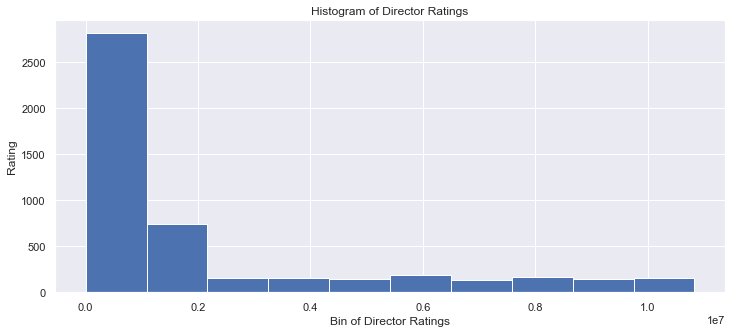

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.hist(final_df.director_rating)
plt.xlabel('Bin of Director Ratings')
plt.ylabel('Rating')
plt.title('Histogram of Director Ratings')
plt.gcf().set_size_inches((12, 5))

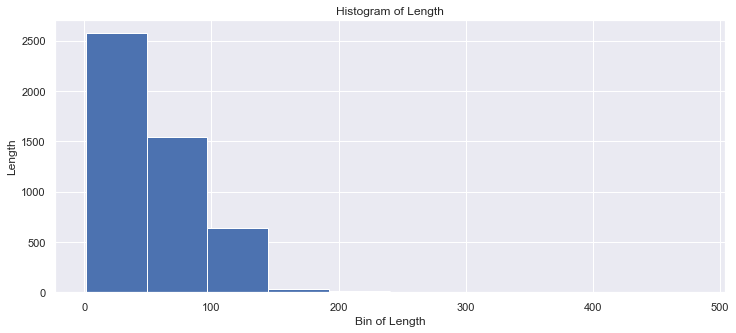

In [32]:
plt.hist(final_df.length)
plt.xlabel('Bin of Length')
plt.ylabel('Length')
plt.title('Histogram of Length')
plt.gcf().set_size_inches((12, 5))

In [ ]:
# read final_df to a CSV file for use in report notebook
final_df.to_csv('final.csv', index=False)